# In this file we calibrate the rough Heston model through the pointwise approach
In the forward pass we learn the **mapping** between **Heston parameters** and the option **implied volatility**, In this case the implied volatility surface is on a fixed grid 11(strikes)x8(maturities), the same used for the image based approach, here we will unroll it in order to handle the single option.
Below we upload the dataset .

In [1]:
#Set the directory of stored dataset
import os
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/rHeston/pointwise")

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#Open compressed dataset

file_path = "rHestonflatFixedGridsDataset.csv"
df=pd.read_csv(file_path) #load data in a numpy array
clean_data = df.iloc[:, :6].values
xx = df.iloc[:, :4].values   #extract first 4 columns (rHeston parameters)
clean_ivs = df.iloc[:, 6].values

#define strikes and maturities
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

# Print shapes with descriptive messages
print("\nInput (rHeston parameter sets) shape (samples × 4 parameters):", xx.shape)
print("\n  - Each row contains: [H, γ, ρ, ν₀]")
print("\nShape clean_data:", clean_data.shape)  # Should be (14032*88, 6)
print("\nShape clean_ivs:", clean_ivs.shape)    # Should be (14032*88,)
print("\nFirst 3 rows of clean data:")
print(clean_data[:3])
print("\nFirst 3 implied vols:")
print(clean_ivs[:3])


Input (rHeston parameter sets) shape (samples × 4 parameters): (1234816, 4)

  - Each row contains: [H, γ, ρ, ν₀]

Shape clean_data: (1234816, 6)

Shape clean_ivs: (1234816,)

First 3 rows of clean data:
[[ 0.09988963  0.62535715 -0.26080363  0.07983231  0.5         0.1       ]
 [ 0.09988963  0.62535715 -0.26080363  0.07983231  0.6         0.1       ]
 [ 0.09988963  0.62535715 -0.26080363  0.07983231  0.7         0.1       ]]

First 3 implied vols:
[0.64872359 0.56231116 0.47992252]


# Let's have a look at the dataset and gain some more informations


=== rHESTON PARAMETERS ANALYSIS (xx) ===
       H (Hurst exponent)  ν (vol of variance)  ρ (spot-vol correlation)  \
count          14032.0000           14032.0000                14032.0000   
mean               0.1229               0.4196                   -0.4120   
std                0.0679               0.1371                    0.1710   
min                0.0100               0.1501                   -0.7000   
1%                 0.0118               0.1607                   -0.6941   
5%                 0.0209               0.1929                   -0.6719   
50%                0.1200               0.4249                   -0.4167   
95%                0.2346               0.6274                   -0.1349   
99%                0.2468               0.6457                   -0.1077   
max                0.2500               0.6499                   -0.1000   

       ν₀ (initial variance)  
count             14032.0000  
mean                  0.0716  
std                   0.0355

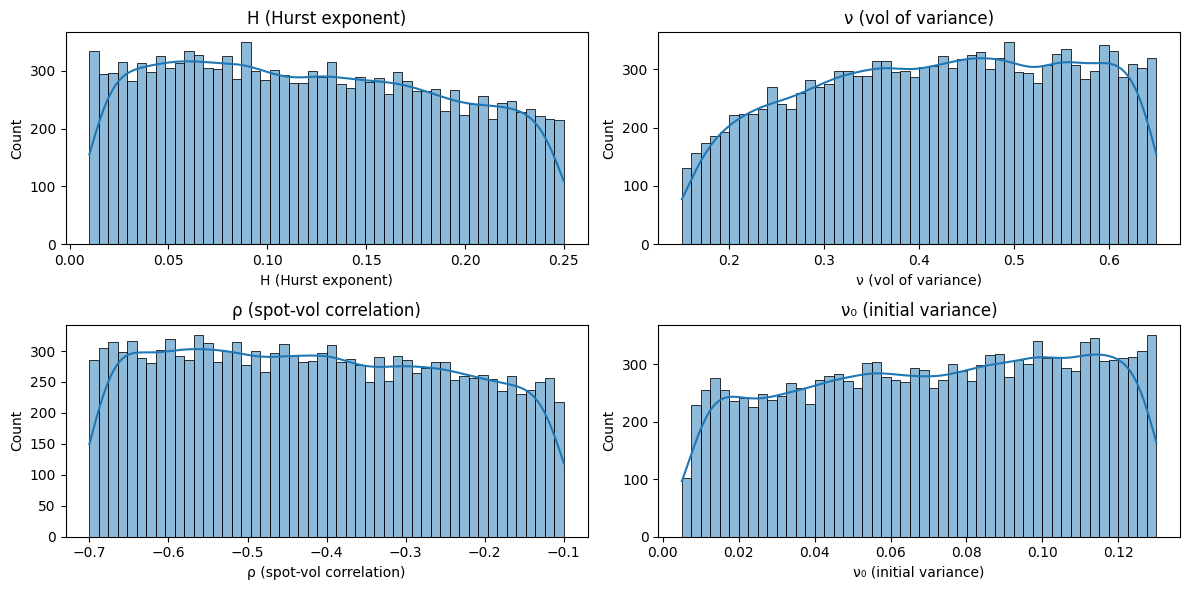

In [3]:
import seaborn as sns

#INPUT (rHESTON PARAMETERS) ANALYSIS 

# rHeston parameter names (for clarity)
#H     ∈ [0.01, 0.25]        (Hurst exponent)
#ν     ∈ [0.15, 0.65]        (initial variance)
#ρ     ∈ [-0.7, -0.1]        (spot-vol correlation)
#ν₀    ∈ [0.005, 0.13]       (vol of variance)

param_names = [
    'H (Hurst exponent)',
    'ν (vol of variance)',
    'ρ (spot-vol correlation)',
    'ν₀ (initial variance)'
]


# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(xx[::88,:], columns=param_names)

# Descriptive statistics
print("\n=== rHESTON PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ν₀:    Min={df_xx.iloc[:,3].min():.4f}, Max={df_xx.iloc[:,3].max():.4f} (Expected: ~[0.005, 0.13])")
print(f"ρ:   Min={df_xx.iloc[:,2].min():.4f}, Max={df_xx.iloc[:,2].max():.4f} (Expected: ~[-0.7, -0.1])")
print(f"H: Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.01, 0.25])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Train-val-test split
In the following snippet we perform the usual trainining-validation-test split, but we need to be careful, this split is not completely random. In fact we need to handle the dataset not at a single-option level, but to parameter set level, meaning that we need to **preserve the integrity** of each surface referring to a parameter set, ESPECIALLY on the test set, where we will calibrate each IV surface.

In [4]:
def split_parameter_blocks(X_pw, y_pw, points_per_sample=88, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    """
    Splits the dataset into train/val/test sets while keeping all strike-maturity combinations
    for each rHeston parameter set together (no mixing of parameter sets across splits).
    
    Args:
        X_pw: Pointwise features array (n_samples*n_points, 6) [H, γ, ρ, ν₀,strike,maturity]
        y_pw: Pointwise target array (n_samples*n_points,) [implied_vols]
        points_per_sample: Number of points per parameter set (default 88)
        train_ratio: Fraction of parameter sets for training
        val_ratio: Fraction of parameter sets for validation
        test_ratio: Fraction of parameter sets for testing
        random_seed: Optional random seed for reproducibility
        
    Returns:
        Tuple of (X_train, y_train), (X_val, y_val), (X_test, y_test)
    """
    # Verify ratios sum to 1
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Ratios must sum to 1"
    
    # Calculate number of unique parameter sets
    n_samples = len(X_pw) // points_per_sample
    assert len(X_pw) == n_samples * points_per_sample, "Data length doesn't match expected samples*points"
    
    print(f"Total parameter sets: {n_samples}")
    print(f"Points per parameter set: {points_per_sample}")
    print(f"Total points: {len(X_pw)}")
    
    # Create sample indices (0,0,0..., 1,1,1..., etc.)
    sample_indices = np.repeat(np.arange(n_samples), points_per_sample)
    
    # Split parameter set indices (not the points themselves)
    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(n_samples)
    
    train_end = int(n_samples * train_ratio)
    val_end = train_end + int(n_samples * val_ratio)
    
    train_samples = shuffled_indices[:train_end]
    val_samples = shuffled_indices[train_end:val_end]
    test_samples = shuffled_indices[val_end:]
    
    print(f"\nSplit counts:")
    print(f"Training parameter sets: {len(train_samples)} ({len(train_samples)/n_samples:.1%})")
    print(f"Validation parameter sets: {len(val_samples)} ({len(val_samples)/n_samples:.1%})")
    print(f"Test parameter sets: {len(test_samples)} ({len(test_samples)/n_samples:.1%})")
    
    # Create masks for each split
    train_mask = np.isin(sample_indices, train_samples)
    val_mask = np.isin(sample_indices, val_samples)
    test_mask = np.isin(sample_indices, test_samples)
    
    # Apply masks to get splits
    X_train, y_train = X_pw[train_mask], y_pw[train_mask]
    X_val, y_val = X_pw[val_mask], y_pw[val_mask]
    X_test, y_test = X_pw[test_mask], y_pw[test_mask]
    
    # Verification checks
    assert len(X_train) == len(train_samples) * points_per_sample
    assert len(X_val) == len(val_samples) * points_per_sample
    assert len(X_test) == len(test_samples) * points_per_sample
    
    # Verify no overlapping parameter sets between splits
    assert len(set(train_samples) & set(val_samples)) == 0
    assert len(set(train_samples) & set(test_samples)) == 0
    assert len(set(val_samples) & set(test_samples)) == 0
    
    print("\nVerification passed - all parameter sets remain intact in their respective splits")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# Example usage:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    split_parameter_blocks(clean_data, clean_ivs, points_per_sample=88,
                          train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                          random_seed=42)

# Verification prints
print("\n=== Split Shapes ===")
print(f"Training set: {X_train.shape} (should be ~{len(clean_data)*0.7:.0f} points)")
print(f"Validation set: {X_val.shape} (should be ~{len(clean_data)*0.15:.0f} points)")
print(f"Test set: {X_test.shape} (should be ~{len(clean_data)*0.15:.0f} points)")

print("\n=== Sample Distribution ===")
print(f"First training sample params: {X_train[0][:4]}")
print(f"First validation sample params: {X_val[0][:4]}")
print(f"First test sample params: {X_test[0][:4]}")

Total parameter sets: 14032
Points per parameter set: 88
Total points: 1234816

Split counts:
Training parameter sets: 9822 (70.0%)
Validation parameter sets: 2104 (15.0%)
Test parameter sets: 2106 (15.0%)

Verification passed - all parameter sets remain intact in their respective splits

=== Split Shapes ===
Training set: (864336, 6) (should be ~864371 points)
Validation set: (185152, 6) (should be ~185222 points)
Test set: (185328, 6) (should be ~185222 points)

=== Sample Distribution ===
First training sample params: [ 0.09988963  0.62535715 -0.26080363  0.07983231]
First validation sample params: [ 0.02561238  0.62444277 -0.12062078  0.10604967]
First test sample params: [ 0.04744447  0.22799726 -0.66514983  0.11327202]


# Scaling:
Now we can finally scale both the parameters as shown below and the implied volatilities, this will improve the numerical stability of the training and calibration procedure.

# Model Parameters ${\theta}_{i=1,..,4}\to scale(\theta_i)\in[-1,1]$
## $scale(\theta_i)=\frac{2\theta_i-(\theta_i^{max}+\theta_i^{min})}{\theta_i^{max}-\theta_i^{min}},\quad i \in |\Theta|$

# Implied volatilities
## $$scale(\sigma^{BS}_{i,j})=\frac{\sigma^{BS}_{i,j}-\mathbb{E}[\sigma^{BS}_{i,j}]}{std(\sigma^{BS}_{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [5]:
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

# =================================================================
# 1. IMPLIED VOLATILITY SCALING (StandardScaler)
# =================================================================
scaler_yy = StandardScaler()

# Reshape y arrays to 2D if needed (StandardScaler expects 2D input)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Apply scaling
y_train_transform = scaler_yy.fit_transform(y_train)  # Compute μ and σ on training set
y_val_transform = scaler_yy.transform(y_val)          # Use same μ and σ
y_test_transform = scaler_yy.transform(y_test)        # Use same μ and σ

# Inverse transform function
def yinversetransform(y_scaled):
    """Convert scaled volatilities back to original scale"""
    return scaler_yy.inverse_transform(y_scaled)

# ========================================================================
#2-Custom [-1,1] rHeston parameter scaling, define rHeston parameter's upper and lower bounds
# ===============================================================================
#H     ∈ [0.01, 0.25]        (Hurst exponent)
#ν     ∈ [0.15, 0.65]        (initial variance)
#ρ     ∈ [-0.7, -0.1]        (spot-vol correlation)
#ν₀    ∈ [0.005, 0.13]       (vol of variance)

#parameters order is: [H, ν, ρ, ν₀]

ub=np.array([0.25,0.65,-0.1,0.13])
lb=np.array([0.01,0.15,-0.7,0.005])

def myscale(x):
    """
    Scale rHeston parameters to [-1,1] range while preserving strike/maturity
    Args:
        x: Input array (n_points, 6) where cols 0-3 are rHeston params, 4-5 are strike/maturity
    Returns:
        Scaled array with same shape, only rHeston params transformed
    """
    x_scaled = x.copy()
    # Only scale first 4 columns (rHeston params)
    for i in range(4):
        x_scaled[:,i] = (2*x[:,i] - (ub[i] + lb[i])) / (ub[i] - lb[i])
    return x_scaled

def myinverse(x_scaled):
    """
    Convert scaled rHeston params back to original scale
    Args:
        x_scaled: Scaled array (n_points, 6)
    Returns:
        Array with rHeston params in original scale
    """
    x_original = x_scaled.copy()
    for i in range(4):
        x_original[:,i] = x_scaled[:,i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5
    return x_original

# Apply scaling (only to rHeston params, leave strike/maturity unchanged)
x_train_transform = myscale(X_train)
x_val_transform = myscale(X_val)
x_test_transform = myscale(X_test)

# =================================================================
# VERIFICATION
# =================================================================
def verify_scaling(original, scaled, param_names):
    """Check scaling was correctly applied"""
    print("\nScaling verification for:", param_names)
    for i in range(4):  # Only check rHeston params
        orig_min, orig_max = original[:,i].min(), original[:,i].max()
        scaled_min, scaled_max = scaled[:,i].min(), scaled[:,i].max()
        print(f"{param_names[i]:<6}: [{orig_min:.4f},{orig_max:.4f}] -> [{scaled_min:.4f},{scaled_max:.4f}]")
    
    # Verify strike/maturity unchanged
    assert np.allclose(original[:,4:], scaled[:,4:]), "Strike/maturity values were modified!"

print("=== Scaling Verification ===")
verify_scaling(X_train, x_train_transform, ["H", "ν", "ρ", "ν₀"])

# =================================================================
# DATASET SUMMARY
# =================================================================
shape_data = [
    ["Training", x_train_transform.shape, y_train_transform.shape],
    ["Validation", x_val_transform.shape, y_val_transform.shape], 
    ["Test", x_test_transform.shape, y_test_transform.shape]
]

print("\n=== Scaled Dataset Shapes ===")
print(tabulate(shape_data,
               headers=["Split", "Features Shape", "Target Shape"],
               tablefmt="grid",
               stralign="center"))

print("\nKey Notes:")
print("- Only rHeston parameters (first 4 columns) were scaled to [-1,1] range")
print("- Strike and maturity values (last 2 columns) remain in original scale")
print("- Implied volatilities were standardized using z-score scaling")

=== Scaling Verification ===

Scaling verification for: ['H', 'ν', 'ρ', 'ν₀']
H     : [0.0100,0.2500] -> [-0.9998,0.9999]
ν     : [0.1501,0.6499] -> [-0.9998,0.9995]
ρ     : [-0.7000,-0.1001] -> [-1.0000,0.9997]
ν₀    : [0.0051,0.1300] -> [-0.9989,0.9998]

=== Scaled Dataset Shapes ===
+------------+------------------+----------------+
|   Split    |  Features Shape  |  Target Shape  |
+============+==================+================+
|  Training  |   (864336, 6)    |  (864336, 1)   |
+------------+------------------+----------------+
| Validation |   (185152, 6)    |  (185152, 1)   |
+------------+------------------+----------------+
|    Test    |   (185328, 6)    |  (185328, 1)   |
+------------+------------------+----------------+

Key Notes:
- Only rHeston parameters (first 4 columns) were scaled to [-1,1] range
- Strike and maturity values (last 2 columns) remain in original scale
- Implied volatilities were standardized using z-score scaling


# CaNN: Calibration Neural Network
Step 1: *Forward Pass*
Now we can train the network to learn the **mapping** from: rHeston + **fixed** contract parameters -> implied volatility. we can set up our neural network composed of:

- **4 hidden layers**, each with **30 neurons**  
- **output layer** with 1 neuron, here we select a **linear** activation function because of the preprocessing of implied volatilities
- **Activation function**: **Elu** , $\sigma_{Elu}=\alpha(e^x -1)$ in all the layers, its smoothness is crucial for the approximation of the Loss function
- **Batch size**: **1024**  
- **Optimizer**: **Adam**  
- **Early stopping**: with patience set to 40 epochs, maximum number of epochs being 400
- **Loss**: MSE

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Set precision to float64
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(42)  # For consistent initialization

# Build the model
inputs = Input(shape=(6,), name='input_layer')
x1 = Dense(30, activation='elu', name='hidden_1')(inputs)
x2 = Dense(30, activation='elu', name='hidden_2')(x1) 
x3 = Dense(30, activation='elu', name='hidden_3')(x2) 
x4 = Dense(30, activation='elu', name='hidden_4')(x3)
outputs = Dense(1, activation='linear', name='output_layer')(x4)

modelpoint = Model(inputs=inputs, outputs=outputs, name = 'point_model')
modelpoint.summary()

Model: "point_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 30)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,031 (23.68 KB)

 Trainable params: 3,031 (23.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2217 - val_loss: 0.0134
Epoch 2/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0102 - val_loss: 0.0055
Epoch 3/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 4/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 9.6643e-04 - val_loss: 0.0010
Epoch 8/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.0636e-04 - val_loss: 8.7372e-04
Epoch 9/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.0740e-04 - val_loss: 7.4128e-04
Epoch 10/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.3542e-04 - val_loss: 6.4273e-04
Epoch 11/400
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.8186e-04 - val_loss: 5.9535e-04
Epoch

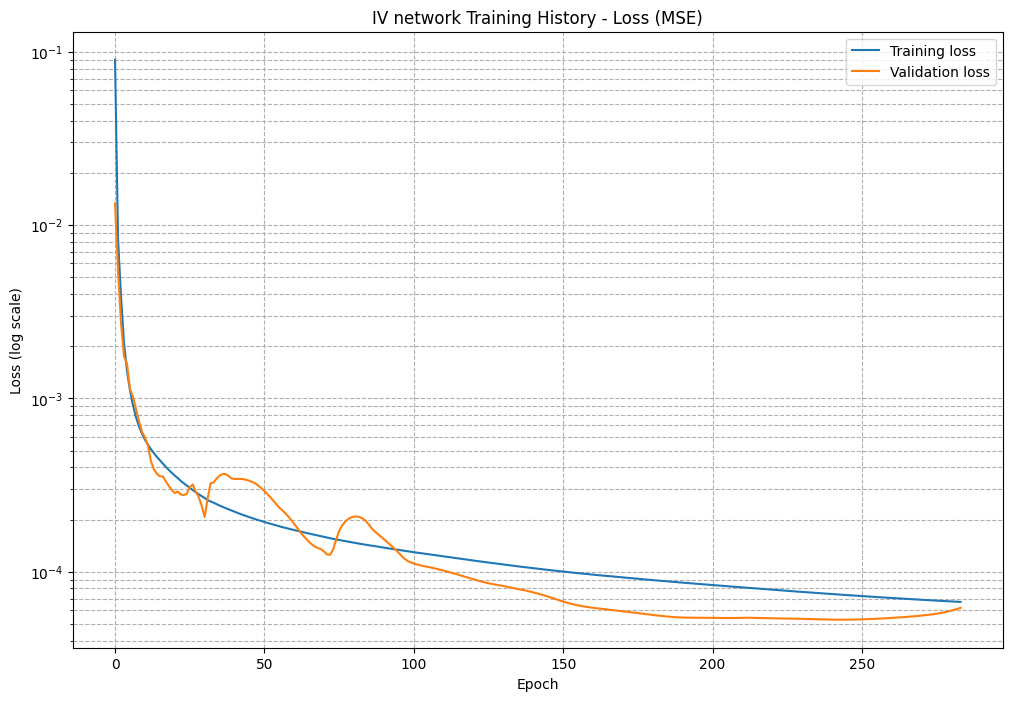


Final Training Loss: 6.6902e-05
Final Validation Loss: 6.1848e-05


In [7]:
import time
# EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss', 
    patience=40,       
    verbose=1,       
    restore_best_weights=True  # Restore the best model weights
)

# Callbacks
#reduce_lr = ReduceLROnPlateau(
#        monitor='val_loss',
#        factor=0.5,
#        patience=20,
#        min_lr=5e-5,
 #       verbose=1
 #   )

# Compile the model
modelpoint.compile(loss="mse", optimizer="adam")

# Train the model
start=time.time()
history = modelpoint.fit(
    x_train_transform, 
    y_train_transform, 
    batch_size=1024,
    validation_data=(x_val_transform, y_val_transform),
    epochs=400, 
    verbose=1, 
    shuffle=True, 
    callbacks=[earlystop]
)
end=time.time()
training_time=(end-start)
print("Training time :" ,training_time , "s" )

# Plot training history
plt.figure(figsize=(12, 8))  
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.title('IV network Training History - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.4e}")
print(f"Final Validation Loss: {final_val_loss:.4e}")

# Evaluate the map on test data

5792/5792 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

=== Performance on Standardized Scale ===
- MSE: 0.000046
- RMSE: 0.006819
- MAE: 0.004149

=== Performance on Original Scale ===
- MSE: 0.0000004
- RMSE: 0.000639 (0.24% of mean IV)
- MAE: 0.000389 (0.14% of mean IV)


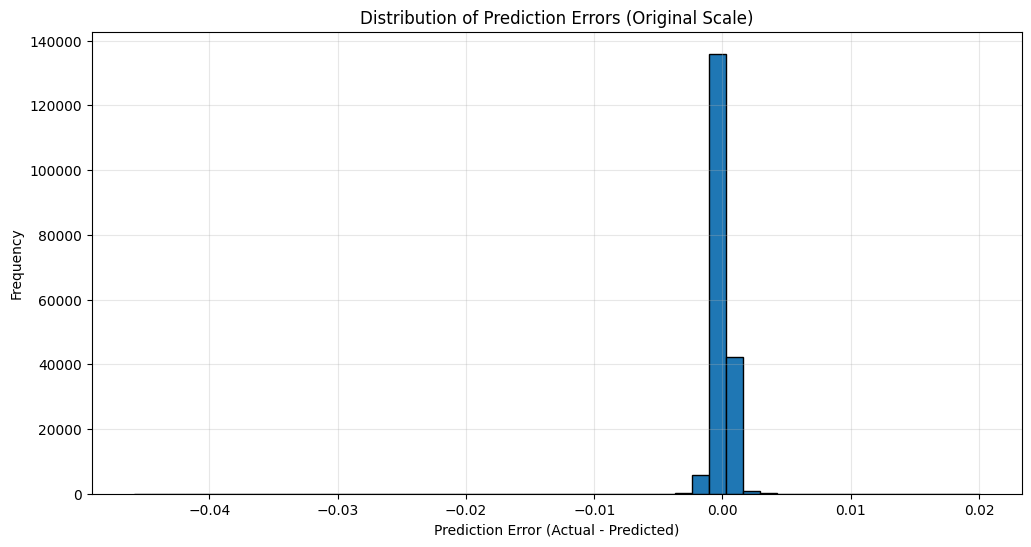

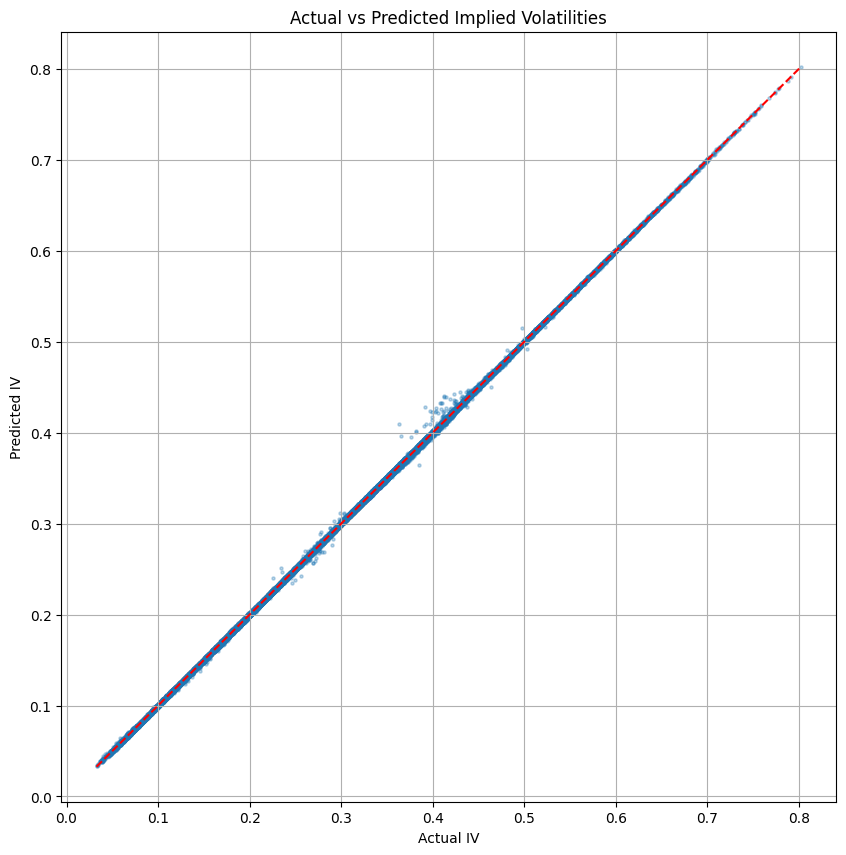

In [8]:
# Calculate predictions on test set
y_pred_transformed = modelpoint.predict(x_test_transform, verbose=1)

# 1) Evaluation on transformed scale (standardized volatilities)
mse_transformed = np.mean(np.square(y_test_transform - y_pred_transformed))
rmse_transformed = np.sqrt(mse_transformed)
mae_transformed = np.mean(np.abs(y_test_transform - y_pred_transformed))

print("\n=== Performance on Standardized Scale ===")
print(f"- MSE: {mse_transformed:.6f}")
print(f"- RMSE: {rmse_transformed:.6f}")
print(f"- MAE: {mae_transformed:.6f}")

# 2) Evaluation on original scale (implied volatilities)
y_pred_original = yinversetransform(y_pred_transformed)

mse_original = np.mean(np.square(y_test - y_pred_original))
rmse_original = np.sqrt(mse_original)
mae_original = np.mean(np.abs(y_test - y_pred_original))
mean_iv = np.mean(y_test)  # Reference for relative error

print("\n=== Performance on Original Scale ===")
print(f"- MSE: {mse_original:.7f}")
print(f"- RMSE: {rmse_original:.6f} ({(rmse_original/mean_iv)*100:.2f}% of mean IV)")
print(f"- MAE: {mae_original:.6f} ({(mae_original/mean_iv)*100:.2f}% of mean IV)")

# 3) Error distribution analysis
errors = y_test - y_pred_original
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribution of Prediction Errors (Original Scale)')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# 4) Scatter plot of predictions vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_original, alpha=0.3, s=5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Implied Volatilities')
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.grid(True)
plt.show()


Reshaping verification:
Original first maturity, first strike: 0.5773, Predicted: 0.5761
Reshaped [0,0,0]: 0.1967%
Original last maturity, last strike: 0.2758, Predicted: 0.2753
Reshaped [-1,-1,-1]: 0.1616%


C:\Users\pc\AppData\Local\Temp\ipykernel_13556\322144069.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Original first maturity, first strike: {float(y_test[0]):.4f}, Predicted: {float(y_pred_original[0]):.4f}")
C:\Users\pc\AppData\Local\Temp\ipykernel_13556\322144069.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Original last maturity, last strike: {float(y_test[-1]):.4f}, Predicted: {float(y_pred_original[-1]):.4f}")


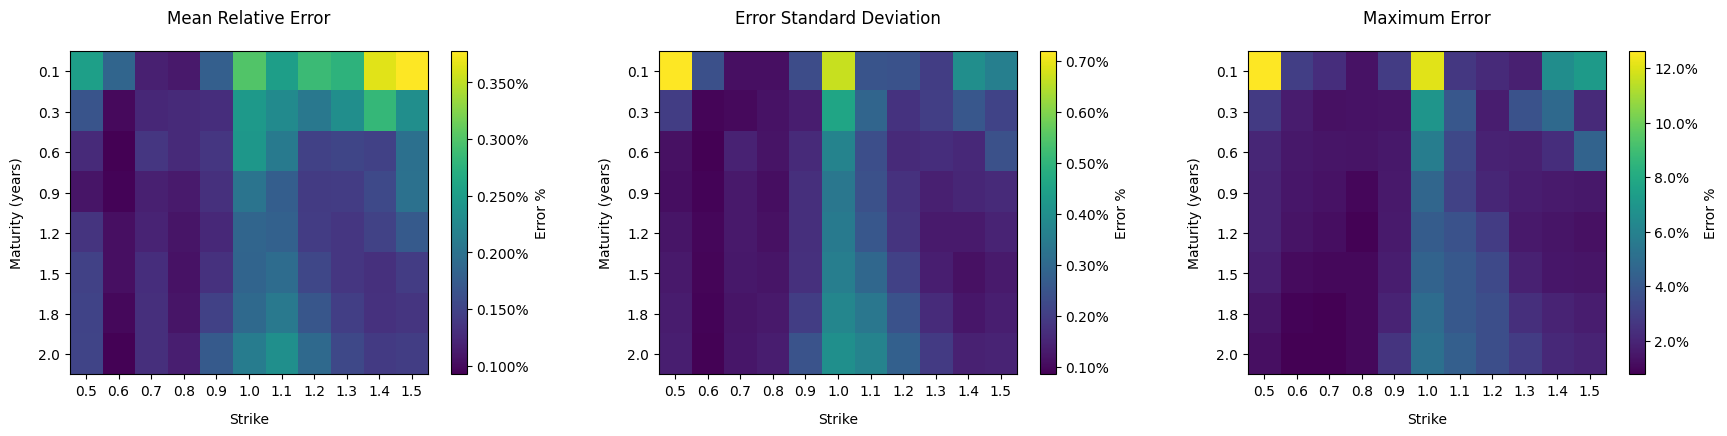


Error Statistics Across Entire Test Set:
Mean Error: 0.17%
Median Error: 0.11%
95th Percentile: 0.49%


In [10]:
# FURTHER INVESTIGATE THE ERRORS THE IV SURFACE.

# 1. Ensure shapes are correct
assert y_test.shape == y_pred_original.shape, "Shapes of y_test and y_pred_original must match"
n_samples = len(y_test) // (len(maturities) * len(strikes))
assert len(y_test) == n_samples * len(maturities) * len(strikes), "Total points must match n_samples × maturities × strikes"

# 2. Calculate relative errors (percentage)
relative_errors = np.abs((y_test - y_pred_original) / y_test) * 100  # Shape: (n_points,)
relative_errors = relative_errors.squeeze()

# 3. Reshape errors to (n_samples, 8 maturities, 11 strikes)
try:
    relative_errors_reshaped = relative_errors.reshape(n_samples, len(maturities), len(strikes))
except ValueError as e:
    raise ValueError(f"Reshape failed. Total points: {len(y_test)}, Expected shape: {n_samples}x{len(maturities)}x{len(strikes)}") from e

# 4. Verify reshaping order
print("\nReshaping verification:")
print(f"Original first maturity, first strike: {float(y_test[0]):.4f}, Predicted: {float(y_pred_original[0]):.4f}")
print(f"Reshaped [0,0,0]: {float(relative_errors_reshaped[0,0,0]):.4f}%")
print(f"Original last maturity, last strike: {float(y_test[-1]):.4f}, Predicted: {float(y_pred_original[-1]):.4f}")
print(f"Reshaped [-1,-1,-1]: {float(relative_errors_reshaped[-1,-1,-1]):.4f}%")

# 5. Create error plots
plt.figure(figsize=(18, 5))

# Plot 1: Mean Relative Error
plt.subplot(1, 3, 1)
mean_error = np.mean(relative_errors_reshaped, axis=0)
im1 = plt.imshow(mean_error, origin='upper', aspect='auto', cmap="viridis")
plt.colorbar(im1, label='Error %', format=mtick.PercentFormatter())
plt.title("Mean Relative Error", pad=20)
plt.xlabel("Strike", labelpad=10)
plt.ylabel("Maturity (years)", labelpad=10)
plt.xticks(np.arange(len(strikes)), [f"{s}" for s in strikes])
plt.yticks(np.arange(len(maturities)), [f"{m}" for m in maturities])

# Plot 2: Standard Deviation
plt.subplot(1, 3, 2)
std_error = np.std(relative_errors_reshaped, axis=0)
im2 = plt.imshow(std_error, origin='upper', aspect='auto', cmap="viridis")
plt.colorbar(im2, label='Error %', format=mtick.PercentFormatter())
plt.title("Error Standard Deviation", pad=20)
plt.xlabel("Strike", labelpad=10)
plt.ylabel("Maturity (years)", labelpad=10)
plt.xticks(np.arange(len(strikes)), [f"{s}" for s in strikes])
plt.yticks(np.arange(len(maturities)), [f"{m}" for m in maturities])

# Plot 3: Maximum Error
plt.subplot(1, 3, 3)
max_error = np.max(relative_errors_reshaped, axis=0)
im3 = plt.imshow(max_error, origin='upper', aspect='auto', cmap="viridis")
plt.colorbar(im3, label='Error %', format=mtick.PercentFormatter())
plt.title("Maximum Error", pad=20)
plt.xlabel("Strike", labelpad=10)
plt.ylabel("Maturity (years)", labelpad=10)
plt.xticks(np.arange(len(strikes)), [f"{s}" for s in strikes])
plt.yticks(np.arange(len(maturities)), [f"{m}" for m in maturities])

plt.tight_layout(pad=3.0)
plt.show()

# Additional diagnostics
print("\nError Statistics Across Entire Test Set:")
print(f"Mean Error: {np.mean(relative_errors):.2f}%")
print(f"Median Error: {np.median(relative_errors):.2f}%")
print(f"95th Percentile: {np.percentile(relative_errors, 95):.2f}%")

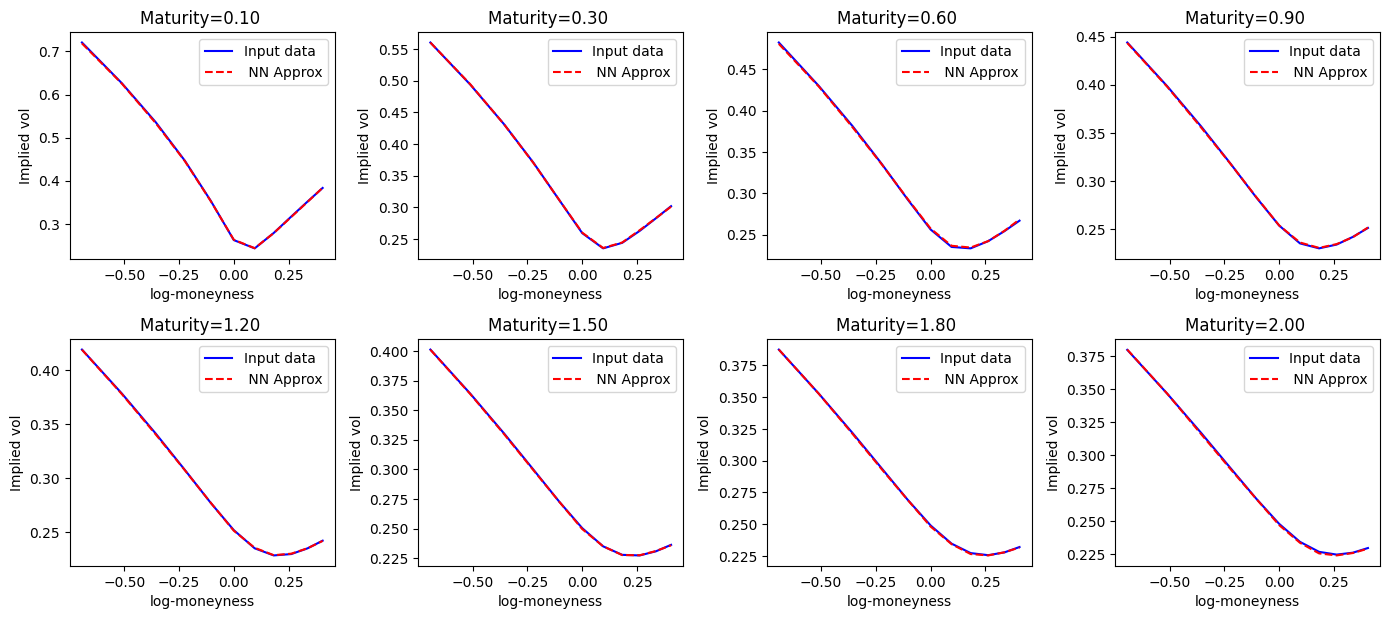

In [10]:
# FINALLY WE PLOT SAMPLE SMILES OF THE TEST SET

# Take a sample index from the test set
sample_ind = 512*88
y_sample = y_test[sample_ind:sample_ind+88].squeeze().T             #take corresponding (not processed)test sample
prediction = y_pred_original[sample_ind:sample_ind+88].squeeze().T  #take corresponding (converted)prediction

S0=1.0  #specify spot price
strikes_dim = len(strikes)

plt.figure(1,figsize=(14,12))
for i in range(len(maturities)):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

# Optimizing the training
Numpy Implementation of the Neural Network tends to be faster than Keras

In [11]:
import scipy.optimize

# =====================================================================================
# EXTRACT TRAINED WEIGHTS FROM KERAS MODEL
# =====================================================================================

def extract_weights_from_keras_model(model):
    weights_and_biases = []
    for layer in model.layers:
        if hasattr(layer, 'get_weights') and layer.get_weights():
            weights, biases = layer.get_weights()
            weights_and_biases.append([weights, biases])
    return weights_and_biases

NNParameters = extract_weights_from_keras_model(modelpoint)

# =====================================================================================
# NUMPY IMPLEMENTATION OF THE NN AND GRADIENT
# =====================================================================================

NumLayers = 4  # Number of hidden layers

def elu(x):
    mask = x < 0
    out = x.copy()
    out[mask] = np.exp(out[mask]) - 1
    return out

def eluPrime(x):
    out = np.ones_like(x)
    mask = x < 0
    out[mask] = np.exp(x[mask])
    return out

def NeuralNetwork(x, strike, maturity):
    full_input = np.concatenate([x, [strike, maturity]])
    input1 = full_input

    for i in range(NumLayers):
        z = input1 @ NNParameters[i][0] + NNParameters[i][1]
        input1 = elu(z)

    output = input1 @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1]
    return output.flatten()[0]

def NeuralNetworkGradient(x, strike, maturity):
    """
    Compute network gradient w.r.t. rHeston parameters only
    Input:
        rHeston_params - array of 4 scaled rHeston parameters
        strike - strike price (fixed)
        maturity - time to maturity (fixed)
    Output: Gradient vector of dimension (4,) - only w.r.t. rHeston params
    """
    # Concatenate full input
    full_input = np.concatenate([x, [strike, maturity]])
    
    # Forward pass with intermediate storage
    activations = [full_input.copy()]
    z_values = []
    
    input1 = full_input.copy()
    
    # Forward pass through hidden layers
    for i in range(NumLayers):
        z = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        input1 = elu(z)
        z_values.append(z)
        activations.append(input1.copy())
    
    # Output layer
    i += 1
    z_out = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
    
    # Backward pass - start from output
    # Initialize gradient w.r.t. full input (6 dimensions)
    grad_full = np.zeros(6)
    
    # Output layer gradient (linear activation, so derivative = 1)
    delta = np.ones(1)  # Scalar output
    
    # Gradient w.r.t. last hidden layer
    grad_hidden = delta.dot(NNParameters[NumLayers][0].T)
    
    # Backpropagate through hidden layers
    for i in reversed(range(NumLayers)):
        # Gradient w.r.t. pre-activation
        grad_z = grad_hidden * eluPrime(z_values[i])
        
        # Gradient w.r.t. input of this layer
        if i == 0:
            # First layer - gradient w.r.t. network input
            grad_full = grad_z.dot(NNParameters[i][0].T)
        else:
            # Hidden layer - gradient w.r.t. previous activation
            grad_hidden = grad_z.dot(NNParameters[i][0].T)
    
    # Return only gradients w.r.t. rHeston parameters (first 4 elements)
    return grad_full[:4]


In [12]:
from typing import Tuple

# =====================================================================================
# PARAMETER SCALING UTILITIES
# =====================================================================================

def unscale_heston_params(scaled_params: np.ndarray) -> np.ndarray:
    """Convert scaled parameters back to original scale"""
    return scaled_params * (ub - lb) * 0.5 + (ub + lb) * 0.5

# =====================================================================================
# SURFACE COST FUNCTION AND GRADIENT (VECTORIZED)
# =====================================================================================

def surface_cost_function(scaled_params: np.ndarray, 
                          strikes: np.ndarray, 
                          maturities: np.ndarray, 
                          market_ivs: np.ndarray) -> tuple[float, np.ndarray]:

    n_points = len(strikes)
    # Prepare input batch
    batch_input = np.column_stack([
        np.tile(scaled_params, (n_points, 1)),
        strikes.reshape(-1, 1),
        maturities.reshape(-1, 1)
    ])

    # Forward pass vectorized
    activations = batch_input.copy()
    for i in range(NumLayers):
        z = activations @ NNParameters[i][0] + NNParameters[i][1]
        activations = elu(z)
    
    outputs = activations @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1]
    outputs = outputs.flatten()

    # Loss
    residuals = outputs - market_ivs
    total_loss = np.sum(residuals**2)

    # Gradient
    total_gradient = np.zeros_like(scaled_params)
    for i in range(n_points):
        grad = NeuralNetworkGradient(scaled_params, strikes[i], maturities[i])
        total_gradient += 2 * residuals[i] * grad

    return total_loss, total_gradient

In [13]:
# Initialize arrays
n_surfaces = 2106
n_methods = 4
n_params = 4

methods = ["L-BFGS-B", "SLSQP", "BFGS", "Levenberg-Marquardt"]
init_guess = np.zeros(4)  # Initial guess in [-1,1] scaled space
bounds = [(-1, 1)] * 4

# Prepare calibration data
calibration_data = []
for i in range(n_surfaces):
    start_idx = i * 88
    end_idx = (i+1) * 88
    strikes = x_test_transform[start_idx:end_idx, 4]
    maturities = x_test_transform[start_idx:end_idx, 5]
    market_ivs = y_test_transform[start_idx:end_idx, 0]
    calibration_data.append((strikes, maturities, market_ivs))

# Main calibration loop

# =====================================================================================
# OPTIMIZATION LOOP
# =====================================================================================

solutions = np.zeros((n_surfaces, n_methods, n_params))  # [surface, method, param]
times = np.zeros((n_surfaces, n_methods))

# Main calibration loop
for surface_idx in range(n_surfaces):
    print(f"Calibrating surface {surface_idx+1}/{n_surfaces}", end="\r")
    strikes, maturities, market_ivs = calibration_data[surface_idx]

    def fun(x):
        loss, _ = surface_cost_function(x, strikes, maturities, market_ivs)
        return loss

    def jac(x):
        _, grad = surface_cost_function(x, strikes, maturities, market_ivs)
        return grad

    def ls_fun(x):
        n = len(strikes)
        return np.array([
            NeuralNetwork(x, strikes[i], maturities[i]) - market_ivs[i]
            for i in range(n)
        ])

    def ls_jac(x):
        n = len(strikes)
        J = np.zeros((n, 4))
        for i in range(n):
            J[i, :] = NeuralNetworkGradient(x, strikes[i], maturities[i])
        return J

    # L-BFGS-B
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='L-BFGS-B', jac=jac,
                                    bounds=bounds, tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 0, :] = unscale_heston_params(res.x)
    times[surface_idx, 0] = t1 - t0

    # SLSQP
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='SLSQP', jac=jac,
                                    bounds=bounds, tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 1, :] = unscale_heston_params(res.x)
    times[surface_idx, 1] = t1 - t0

    # BFGS
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='BFGS', jac=jac,
                                    tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 2, :] = unscale_heston_params(res.x)
    times[surface_idx, 2] = t1 - t0

    # Levenberg-Marquardt
    t0 = time.perf_counter()
    res = scipy.optimize.least_squares(ls_fun, init_guess, jac=ls_jac,
                                        gtol=1e-10)
    t1 = time.perf_counter()
    solutions[surface_idx, 3, :] = unscale_heston_params(res.x)
    times[surface_idx, 3] = t1 - t0

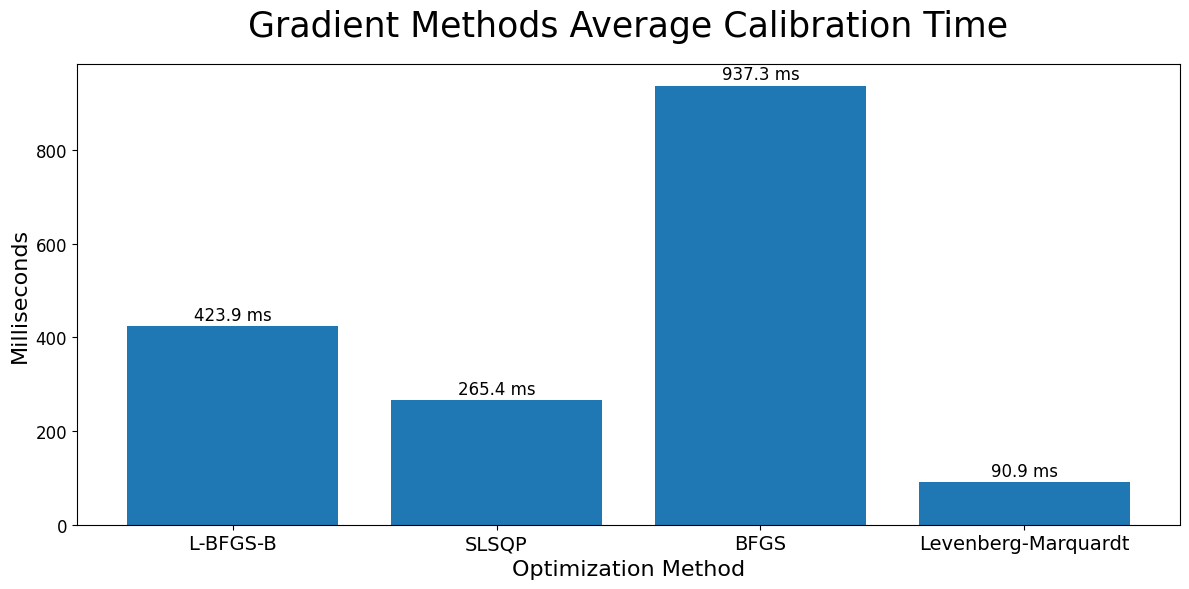

In [14]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Calculate average times in milliseconds
avg_times_ms = np.mean(times, axis=0) * 1000

# Plot settings
plt.figure(1, figsize=(12, 6))
bars = plt.bar(methods, avg_times_ms)

# Add exact numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.1f} ms',
             ha='center', va='bottom', fontsize=12)

# Formatting
plt.title("Gradient Methods Average Calibration Time", fontsize=25, pad=20)
plt.ylabel("Milliseconds", fontsize=16)
plt.xlabel("Optimization Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Adjust layout to prevent text clipping
plt.tight_layout()
plt.show()

Calibrated parameters shape: (2106, 4)
Test parameters shape: (2106, 4)


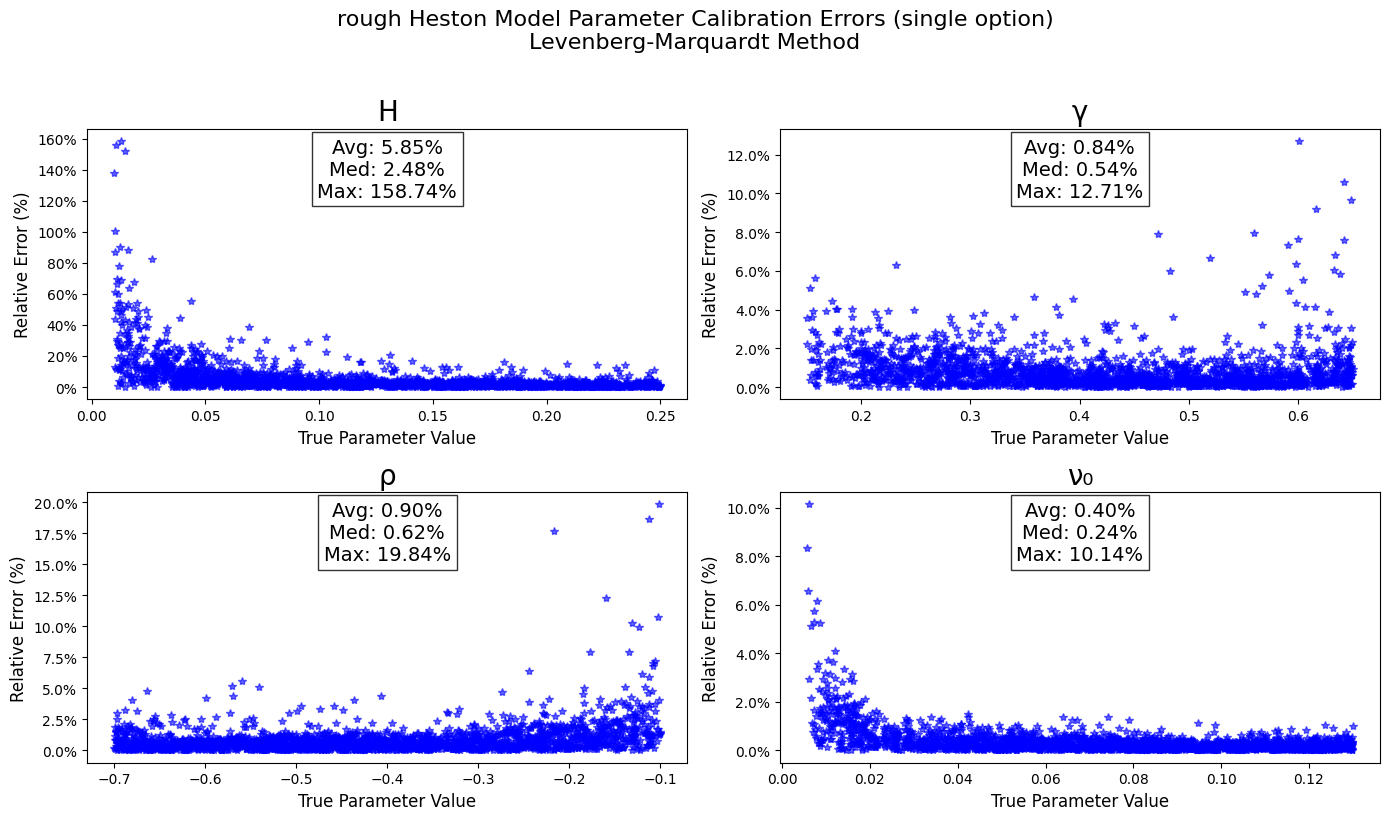


Summary Statistics of Relative Errors (%):
H: Avg=5.85%, Med=2.48%, Max=158.74%
γ: Avg=0.84%, Med=0.54%, Max=12.71%
ρ: Avg=0.90%, Med=0.62%, Max=19.84%
ν₀: Avg=0.40%, Med=0.24%, Max=10.14%


In [20]:
# Extract Levenberg-Marquardt parameters (usually the best performing)
LMParameters = solutions[:, 3, :]

# Extract unique rHeston parameters from X_test (remove duplicates and strike/maturity columns)
# Since parameters are repeated 88 times for each surface, we take every 88th row
X_test_compare = X_test[::88, :4]  # Take every 88th row and first 4 columns

# Verify shapes
print(f"Calibrated parameters shape: {LMParameters.shape}")  # Should be (2106, 4)
print(f"Test parameters shape: {X_test_compare.shape}")      # Should be (2106, 4)

# Verify dimensions
assert len(LMParameters) == len(X_test_compare), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["H", "γ", "ρ", "ν₀"]
relative_errors = np.zeros((len(LMParameters), 4))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate relative errors 
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rough Heston Model Parameter Calibration Errors (single option)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

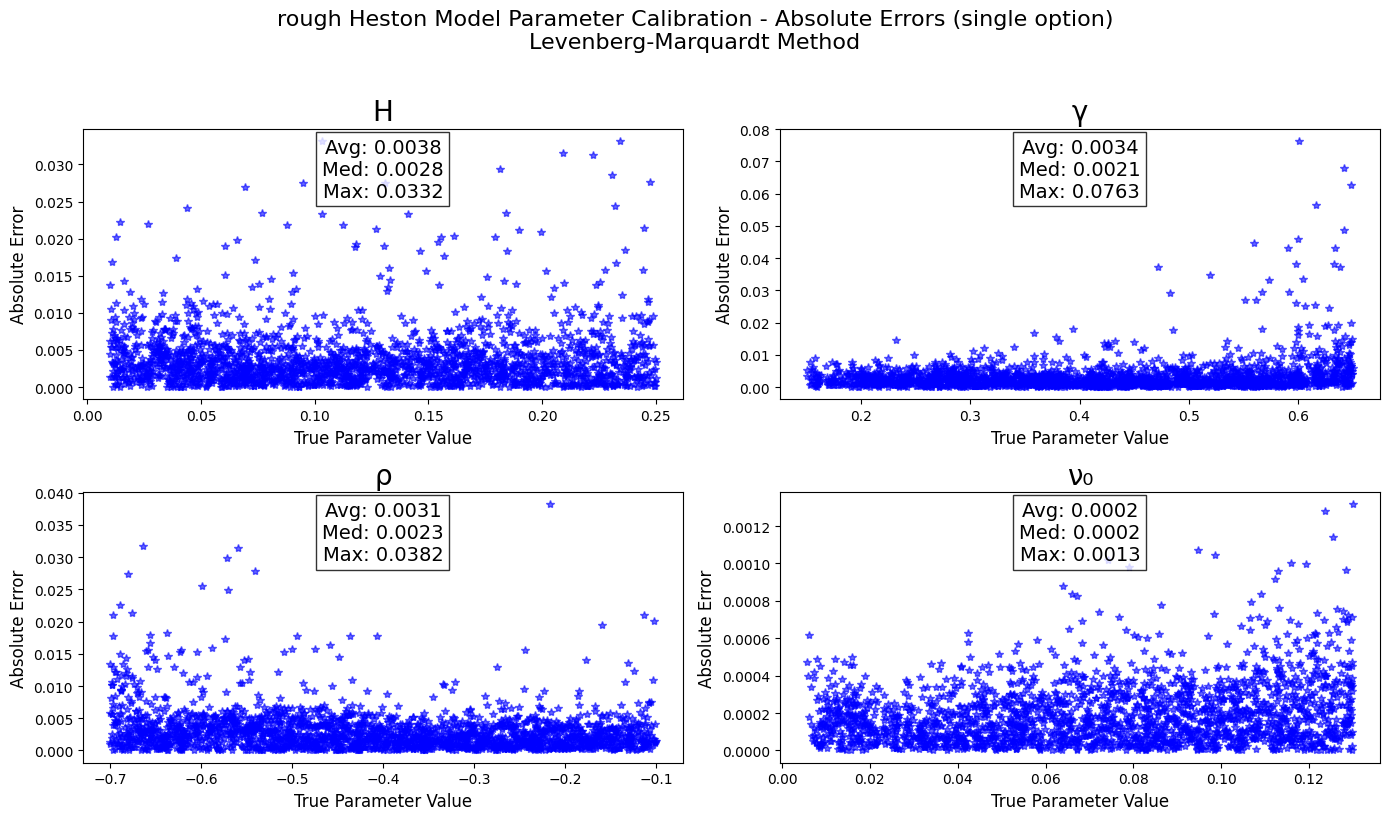


Summary Statistics of Absolute Errors:
H: Avg=0.003805, Med=0.002804, Max=0.033184
γ: Avg=0.003350, Med=0.002119, Max=0.076334
ρ: Avg=0.003123, Med=0.002339, Max=0.038221
ν₀: Avg=0.000194, Med=0.000156, Max=0.001317


In [21]:
# Correct parameter names and absolute error analysis
absolute_errors = np.zeros((len(LMParameters), 4))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rough Heston Model Parameter Calibration - Absolute Errors (single option)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")

# Gradient-free optimization
And here we will exploit 3 different gradient free optimization methods: **COBYLA**, **Differential Evolution** and **Nelder-Mayer**.
We will use this configuration of parameters for these algorithms and compare both accuracy and calibration time.

In [23]:
# =====================================================================================
# GRADIENT-FREE CALIBRATION WITH DIFFERENT ALGORITHMS
# =====================================================================================

# Define parameter bounds in scaled space [-1, 1] for all parameters
bounds_scaled = [(-1, 1) for _ in range(4)]

# Initialize arrays for results
n_surfaces = 100
n_methods = 3
n_params = 4

solutions_gf = np.zeros((n_surfaces, n_methods, n_params))  # [surface, method, param]
times_gf = np.zeros((n_surfaces, n_methods))

methods = ["COBYLA", "Differential Evolution", "Nelder-Mead"]
init_guess = np.zeros(4)  # Initial guess in [-1,1] scaled space

print("Starting Gradient-Free Calibration...")
print(f"Total surfaces to calibrate: {n_surfaces}")

# Main calibration loop
for surface_idx in range(n_surfaces):
    print(f"Calibrating surface {surface_idx+1}/{n_surfaces}", end="\r")
    strikes, maturities, market_ivs = calibration_data[surface_idx]
    
    # Define cost function for this surface, same as before without the gradient (note: it takes directly the current market data being inside the loop, no need to pass them)
    def fun(x):
        loss, _ = surface_cost_function(x, strikes, maturities, market_ivs)
        return loss
    
    # COBYLA (Constrained Optimization BY Linear Approximation)
    start = time.perf_counter()
    result = scipy.optimize.minimize(
        fun,
        x0=init_guess,
        method='COBYLA',
        bounds=bounds_scaled,
        options={
            "maxiter": 5000,
            "disp": False,
            "catol": 1e-8,
            "tol": 1e-10
        }
    )
    solutions_gf[surface_idx, 0, :] = unscale_heston_params(result.x)
    times_gf[surface_idx, 0] = time.perf_counter() - start
    
    # Differential Evolution
    start = time.perf_counter()
    result = scipy.optimize.differential_evolution(
        fun,
        bounds=bounds_scaled,
        popsize=50,
        strategy='best1bin',
        mutation=0.65,
        recombination=0.7,
        tol=0.01,
        maxiter=1000,
        disp=False,
        seed=42
    )
    solutions_gf[surface_idx, 1, :] = unscale_heston_params(result.x)
    times_gf[surface_idx, 1] = time.perf_counter() - start
    
    # Nelder-Mead (Simplex method)
    start = time.perf_counter()
    result = scipy.optimize.minimize(
        fun,
        x0=init_guess,
        method='Nelder-Mead',
        options={
            "maxiter": 5000,
            "maxfev": 10000,
            "disp": False,
            "xatol": 1e-8,
            "fatol": 1e-10,
            "adaptive": True
        }
    )
    solutions_gf[surface_idx, 2, :] = unscale_heston_params(result.x)
    times_gf[surface_idx, 2] = time.perf_counter() - start

print("\nGradient-Free Calibration completed!")

Starting Gradient-Free Calibration...
Total surfaces to calibrate: 100
Calibrating surface 100/100
Gradient-Free Calibration completed!


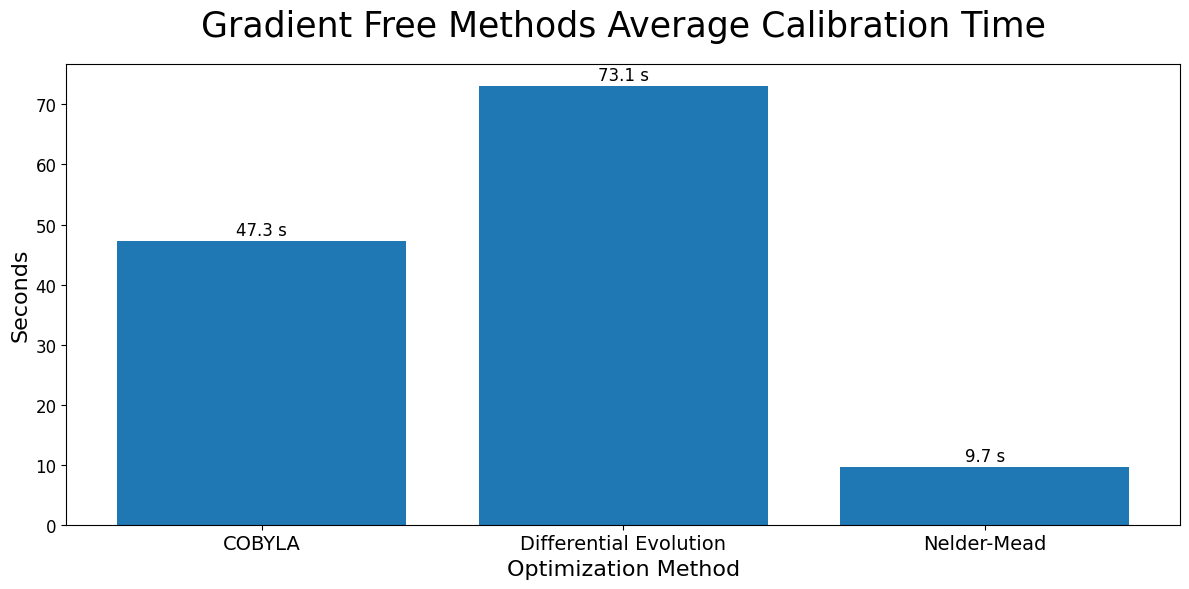

In [24]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Calculate average times in milliseconds
avg_times_ms = np.mean(times_gf, axis=0)

# Plot settings
plt.figure(1, figsize=(12, 6))
bars = plt.bar(methods, avg_times_ms)

# Add exact numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.25,
             f'{height:.1f} s',
             ha='center', va='bottom', fontsize=12)

# Formatting
plt.title("Gradient Free Methods Average Calibration Time", fontsize=25, pad=20)
plt.ylabel("Seconds", fontsize=16)
plt.xlabel("Optimization Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Adjust layout to prevent text clipping
plt.tight_layout()
plt.show()

Calibrated parameters shape: (100, 4)
Test parameters shape: (100, 4)


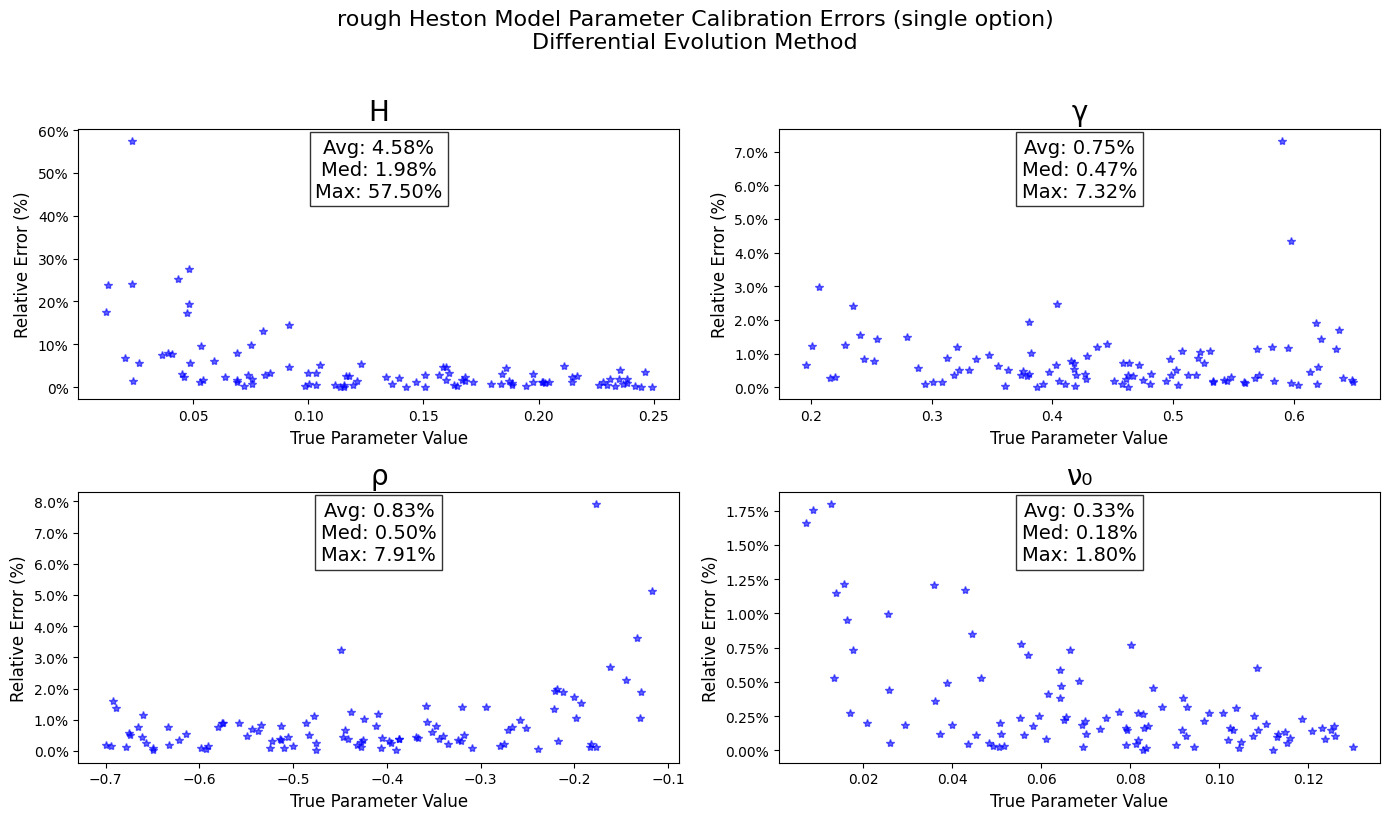


Summary Statistics of Relative Errors (%):
H: Avg=4.58%, Med=1.98%, Max=57.50%
γ: Avg=0.75%, Med=0.47%, Max=7.32%
ρ: Avg=0.83%, Med=0.50%, Max=7.91%
ν₀: Avg=0.33%, Med=0.18%, Max=1.80%


In [25]:
# Extract Differential Evolution parameters (usually the best performing)
DEParameters = solutions_gf[:, 1, :]

# Extract unique rHeston parameters from X_test (remove duplicates and strike/maturity columns)
# Since parameters are repeated 88 times for each surface, we take every 88th row
X_test_compare = X_test[::88, :4]  # Take every 88th row and first 4 columns
X_test_compare = X_test_compare[:n_surfaces,:]

# Verify shapes
print(f"Calibrated parameters shape: {DEParameters.shape}")  # Should be (360, 4)
print(f"Test parameters shape: {X_test_compare.shape}")      # Should be (360, 4)

# Verify dimensions
assert len(DEParameters) == len(X_test_compare), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["H", "γ", "ρ", "ν₀"]
relative_errors = np.zeros((len(DEParameters), 4))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:, param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate relative errors
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rough Heston Model Parameter Calibration Errors (single option)\nDifferential Evolution Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

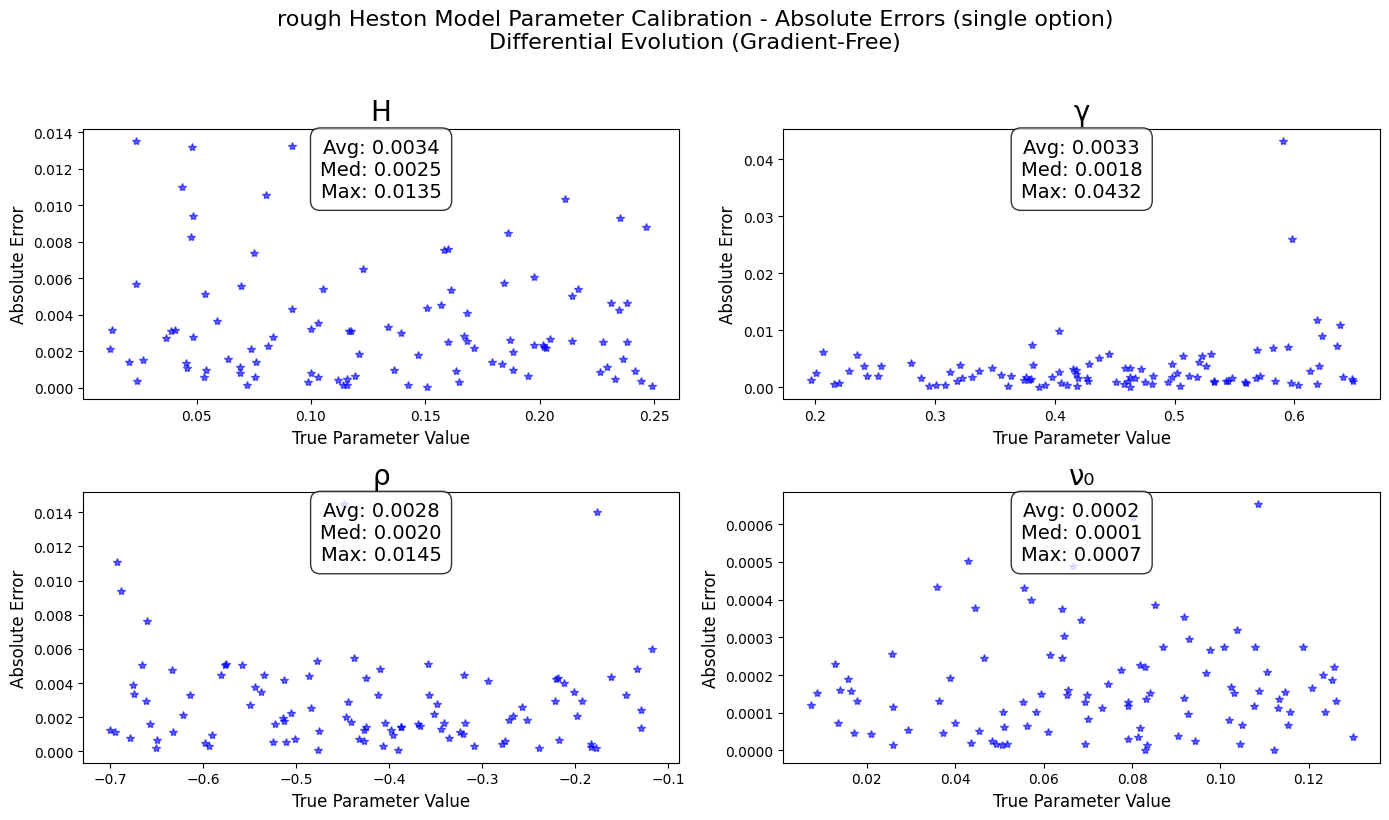


Summary Statistics of Absolute Errors:
H: Avg=0.003381, Med=0.002525, Max=0.013530
γ: Avg=0.003305, Med=0.001850, Max=0.043217
ρ: Avg=0.002781, Med=0.002042, Max=0.014470
ν₀: Avg=0.000168, Med=0.000138, Max=0.000653


In [26]:
# Plot absolute errors for each parameter
titles = ["H", "γ", "ρ", "ν₀"]
absolute_errors = np.zeros((len(DEParameters), 4))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:, param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot with consistent style
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics with consistent formatting
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8,
                      boxstyle='round,pad=0.5'))

plt.suptitle('rough Heston Model Parameter Calibration - Absolute Errors (single option)\nDifferential Evolution (Gradient-Free)', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis with consistent output format
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")